In [2]:
import os
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib_inline
from matplotlib.ticker import AutoMinorLocator, NullFormatter
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, MaxPooling2D, TimeDistributed, \
    Reshape, Flatten, Dense, Dropout, LSTM, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

%matplotlib notebook
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

plt.style.use('/kaggle/input/proplot-stylesheet/proplot_style.mplstyle')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
BASE_PATH = '/kaggle/input/eit-single-touch-datasets'

df_X_nd = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_1_finger_2_dof - ND.xlsx', sheet_name='Voltages')
df_X_sd = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_1_finger_2_dof - SD.xlsx', sheet_name='Voltages')
df_X_sn = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_1_finger_2_dof - SN.xlsx', sheet_name='Voltages')

df_y_nd = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_1_finger_2_dof - ND.xlsx', sheet_name='Positions')
df_y_sd = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_1_finger_2_dof - SD.xlsx', sheet_name='Positions')
df_y_sn = pd.read_excel(BASE_PATH + '/EIT_Data_Gelatin_1_finger_2_dof - SN.xlsx', sheet_name='Positions')

df_y_nd.dropna(inplace=True, axis=1, how='all')
df_y_sd.dropna(inplace=True, axis=1, how='all')
df_y_sn.dropna(inplace=True, axis=1, how='all')

N_nd = 550  # number of rows to use in the datasets
N_sd = 550
N_sn = 3199

X_nd = df_X_nd.iloc[:N_nd].to_numpy()
X_sd = df_X_sd.iloc[:N_sd].to_numpy()
X_sn = df_X_sn.iloc[:N_sn].to_numpy()
y_nd = df_y_nd.iloc[:N_nd].to_numpy()
y_sd = df_y_sd.iloc[:N_sd].to_numpy()
y_sn = df_y_sn.iloc[:N_sn].to_numpy()

print(X_nd.shape, X_sd.shape, X_sn.shape, y_nd.shape, y_sd.shape, y_sn.shape)

# split data into training, testing and validation sets
X_nd_train, X_nd_test, y_nd_train, y_nd_test = train_test_split(X_nd, y_nd, test_size=1/10)
X_sd_train, X_sd_test, y_sd_train, y_sd_test = train_test_split(X_sd, y_sd, test_size=1/10)
X_sn_train, X_sn_test, y_sn_train, y_sn_test = train_test_split(X_sn, y_sn, test_size=1/10)
X_nd_train, X_nd_val, y_nd_train, y_nd_val = train_test_split(X_nd_train, y_nd_train, test_size=1/9)
X_sd_train, X_sd_val, y_sd_train, y_sd_val = train_test_split(X_sd_train, y_sd_train, test_size=1/9)
X_sn_train, X_sn_val, y_sn_train, y_sn_val = train_test_split(X_sn_train, y_sn_train, test_size=1/9)

(550, 1024) (550, 1024) (3199, 1024) (550, 2) (550, 2) (3199, 2)


In [4]:
# train a ridge regression model using grid search cross validation
pipeline_ridge = Pipeline([('scaler', StandardScaler()), ('pca', PCA()),
                           ('poly', PolynomialFeatures()), ('ridge', Ridge())])

# hyperparameter key syntax: 'name in pipeline__attribute'
param_grid_ridge = {'pca__n_components': [2, 32, 128],
                    'poly__degree': [1, 2],
                    'ridge__alpha': [0, 1e-4, 1e-2, 1]}

def train_model(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray,
                pipeline: Pipeline, param_grid: dict[str: list], model_name: str = '',
                cv: int = 9, scoring: str = 'neg_mean_squared_error') -> Pipeline:
    '''
    Train and evaluate a model using grid search cross validation.
    
    #### Arguments
    
    `X` (np.ndarray): full input dataset (features)
    `y` (np.ndarray): full output dataset (target variable)
    `pipeline` (Pipeline): sequence of processing steps and a final estimator.
    `param_grid` (dict[str: list]): set of hyperparameters to search over.
    Key syntax: 'name in pipeline__attribute'
    `test_size` (float, default = 0.2): proportion of dataset to use for testing.
    `cv` (int, default = 10): number of folds in cross validation.
    `scoring` (str, default = 'neg_mean_squared_error'): scoring metric for cross validation.
    
    #### Returns
    
    `Pipeline`: the best model found by grid search cross validation.
    '''
    rmse = lambda y_test, y_pred: mean_squared_error(y_test, y_pred, squared=False)
    search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=scoring)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f'{model_name} - Best hyperparameters: {search.best_params_}')
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'RMSE: {rmse(y_test, y_pred)}')
    return best_model, model_rmse, search.best_params_, y_pred


ridge_nd_model, ridge_nd_rmse, ridge_nd_params, ridge_nd_y_pred = train_model(
    np.vstack((X_nd_train, X_nd_val)), X_nd_test, np.vstack((y_nd_train, y_nd_val)), y_nd_test,
    pipeline_ridge, param_grid_ridge, model_name='Ridge - ND')

ridge_sd_model, ridge_sd_rmse, ridge_sd_params, ridge_sd_y_pred = train_model(
    np.vstack((X_sd_train, X_sd_val)), X_sd_test, np.vstack((y_sd_train, y_sd_val)), y_sd_test,
    pipeline_ridge, param_grid_ridge, model_name='Ridge - SD')

ridge_sn_model, ridge_sn_rmse, ridge_sn_params, ridge_sn_y_pred = train_model(
    np.vstack((X_sn_train, X_sn_val)), X_sn_test, np.vstack((y_sn_train, y_sn_val)), y_sn_test,
    pipeline_ridge, param_grid_ridge, model_name='Ridge - SN')

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.42498e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.51971e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.


Ridge - ND - Best hyperparameters: {'pca__n_components': 2, 'poly__degree': 1, 'ridge__alpha': 0}
RMSE: 0.021869443497350836


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.48932e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/sit

Ridge - SD - Best hyperparameters: {'pca__n_components': 2, 'poly__degree': 1, 'ridge__alpha': 1}
RMSE: 0.020955556185517154


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.0514e-20): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.8401e-20): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  

Ridge - SN - Best hyperparameters: {'pca__n_components': 128, 'poly__degree': 1, 'ridge__alpha': 0.01}
RMSE: 0.018132608655157867


In [5]:
def build_fcnn_model(hp: HyperParameters) -> Sequential:
    model_fcnn = Sequential()
    model_fcnn.add(Input(shape=(1024,)))
    model_fcnn.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu'))
    model_fcnn.add(Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16), activation='relu'))
    model_fcnn.add(Dense(units=2, activation='linear'))
    model_fcnn.compile(optimizer='adam', loss='mse')
    model_fcnn.summary()
    return model_fcnn

'''
nd_sc = StandardScaler().fit(X_nd)
sd_sc = StandardScaler().fit(X_sd)
sn_sc = StandardScaler().fit(X_sn)

X_nd_train_sc = nd_sc.transform(X_nd_train)
X_sd_train_sc = sd_sc.transform(X_sd_train)
X_sn_train_sc = sn_sc.transform(X_sn_train)
X_nd_val_sc = nd_sc.transform(X_nd_val)
X_sd_val_sc = sd_sc.transform(X_sd_val)
X_sn_val_sc = sn_sc.transform(X_sn_val)
X_nd_test_sc = nd_sc.transform(X_nd_test)
X_sd_test_sc = sd_sc.transform(X_sd_test)
X_sn_test_sc = sn_sc.transform(X_sn_test)
'''

fc_nd_tuner = BayesianOptimization(build_fcnn_model, objective='val_loss', max_trials=5)
fc_nd_tuner.search(X_nd_train, y_nd_train, epochs=100, validation_data=(X_nd_val, y_nd_val))
fc_nd_model = fc_nd_tuner.get_best_models(num_models=1)[0]
fc_nd_params = fc_nd_tuner.get_best_hyperparameters(num_trials=1)[0]
fc_nd_history = fc_nd_model.fit(X_nd_train, y_nd_train, epochs=200, batch_size=128,
    validation_data=(X_nd_val, y_nd_val))
fc_nd_y_pred = fc_nd_model.predict(X_nd_test)
fc_nd_rmse = mean_squared_error(y_nd_test, fc_nd_y_pred, squared=False)

fc_sd_tuner = BayesianOptimization(build_fcnn_model, objective='val_loss', max_trials=5)
fc_sd_tuner.search(X_sd_train, y_sd_train, epochs=100, validation_data=(X_sd_val, y_sd_val))
fc_sd_model = fc_sd_tuner.get_best_models(num_models=1)[0]
fc_sd_params = fc_sd_tuner.get_best_hyperparameters(num_trials=1)[0]
fc_sd_history = fc_sd_model.fit(X_sd_train, y_sd_train, epochs=200, batch_size=128,
    validation_data=(X_sd_val, y_sd_val))
fc_sd_y_pred = fc_sd_model.predict(X_sd_test)
fc_sd_rmse = mean_squared_error(y_sd_test, fc_sd_y_pred, squared=False)

fc_sn_tuner = BayesianOptimization(build_fcnn_model, objective='val_loss', max_trials=5)
fc_sn_tuner.search(X_sn_train, y_sn_train, epochs=100, validation_data=(X_sn_val, y_sn_val))
fc_sn_model = fc_sn_tuner.get_best_models(num_models=1)[0]
fc_sn_params = fc_sn_tuner.get_best_hyperparameters(num_trials=1)[0]
fc_sn_history = fc_sn_model.fit(X_sn_train, y_sn_train, epochs=200, batch_size=128,
    validation_data=(X_sn_val, y_sn_val))
fc_sn_y_pred = fc_sn_model.predict(X_sn_test)
fc_sn_rmse = mean_squared_error(y_sn_test, fc_sn_y_pred, squared=False)

print(fc_nd_rmse, fc_sd_rmse, fc_sn_rmse)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65600     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 69,890
Trainable params: 69,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4/4 [==============================] - 2s 63ms/step - loss: 4.8292e-04 - val_loss: 4.5580e-04
Epoch 2/200
4/4 [==============================] - 0s 11ms/step - loss: 5.1152e-04 - val_loss: 4.3527e-04
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 4.4408e-04 - val_loss: 4.2278e-0

In [13]:
FRAME_X, FRAME_Y, GRID_DIV_X, GRID_DIV_Y = 0.08, 0.12, 6, 8

def convert_xy_to_disp_map(positions: list | np.ndarray) -> np.ndarray:
    '''
    Given a set of frame coordinates, return an image-like array showing
    the position of the fingers. It is OK for some of the values to be None,
    which represent empty positions.
        
    ### Arguments
    #### Required
    - `positions` (list | np.ndarray): list of position coordinates
    [x0, x1, ..., y0, y1, ...], in metres in the frame coordinates.
    Shape: (num_trials, 2 * num_fingers) or can be (2 * num_fingers,) if only one.
    #### Optional
        
    ### Returns
    - `np.ndarray`: array of images showing the finger positions. Each array
    will be 1 if there is a press within that tile, and 0 otherwise.
    The radius of the finger is neglected.
    Shape: (num_trials, self.GRID_DIV_X, self.GRID_DIV_Y) or
    (self.GRID_DIV_X, self.GRID_DIV_Y) if only one.
    '''

    tile_x = FRAME_X / GRID_DIV_X
    tile_y = FRAME_Y / GRID_DIV_Y

    if isinstance(positions, list):
        positions = np.array(positions)
    if positions.ndim == 1:
        positions = positions.reshape(1, -1)

    disp_maps = []
    for pos in positions:
        pos = pos[~np.isnan(pos)]  # remove None entries, preserve order
        disp_map = np.zeros((GRID_DIV_X, GRID_DIV_Y))
        x_list = pos[:len(pos) // 2]
        y_list = pos[len(pos) // 2:]
        for x, y in zip(x_list, y_list):
            disp_map[int(x // tile_x), int(y // tile_y)] = 1.0
        disp_maps.append(disp_map)
    return np.array(disp_maps) if len(disp_maps) > 1 else disp_maps[0]


def build_convnet_model(hp: HyperParameters) -> Sequential:
    model_cnn = Sequential()
    model_cnn.add(Input(shape=(1024,)))
    model_cnn.add(Reshape((32, 32, 1)))

    model_cnn.add(Conv2D(hp.Int('units_1', min_value=256, max_value=1024, step=256),
        kernel_size=hp.Choice('size_1', [3, 5, 7, 9]), activation='relu',
        padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    
    model_cnn.add(Conv2D(hp.Int('units_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('size_2', [7, 9, 11, 13]), activation='relu',
        padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dense(6 * 8, activation='sigmoid'))
    model_cnn.add(Reshape((6, 8)))
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model_cnn


def build_convnet_model_simple() -> Sequential:
    model_cnn = Sequential()
    model_cnn.add(Input(shape=(1024,)))
    model_cnn.add(Reshape((32, 32, 1)))
    model_cnn.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Conv2D(64, kernel_size=7, activation='relu', padding='same', data_format='channels_first'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dense(6 * 8, activation='sigmoid'))
    model_cnn.add(Reshape((6, 8)))
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_cnn


y_nd_train_pos = convert_xy_to_disp_map(y_nd_train)
y_sd_train_pos = convert_xy_to_disp_map(y_sd_train)
y_sn_train_pos = convert_xy_to_disp_map(y_sn_train)
y_nd_val_pos = convert_xy_to_disp_map(y_nd_val)
y_sd_val_pos = convert_xy_to_disp_map(y_sd_val)
y_sn_val_pos = convert_xy_to_disp_map(y_sn_val)
y_nd_test_pos = convert_xy_to_disp_map(y_nd_test)
y_sd_test_pos = convert_xy_to_disp_map(y_sd_test)
y_sn_test_pos = convert_xy_to_disp_map(y_sn_test)

###############################

print(X_nd_train.shape, y_nd_train_pos.shape)
'''
cnn_nd_tuner = BayesianOptimization(build_convnet_model, objective='val_loss', max_trials=5)
cnn_nd_tuner.search(X_nd_train, y_nd_train_pos, epochs=100, validation_data=(X_nd_val, y_nd_val_pos))
cnn_nd_model = cnn_nd_tuner.get_best_models(num_models=1)[0]
cnn_nd_params = cnn_nd_tuner.get_best_hyperparameters(num_trials=1)[0]
cnn_nd_history = cnn_nd_model.fit(X_nd_train, y_nd_train_pos, epochs=200, batch_size=128,
    validation_data=(X_nd_val, y_nd_val_pos))
cnn_nd_y_pred_pos = cnn_nd_model.predict(X_nd_test)

cnn_sd_tuner = BayesianOptimization(build_convnet_model, objective='val_loss', max_trials=5)
cnn_sd_tuner.search(X_sd_train, y_sd_train_pos, epochs=100, validation_data=(X_sd_val, y_sd_val_pos))
cnn_sd_model = cnn_sd_tuner.get_best_models(num_models=1)[0]
cnn_sd_params = cnn_sd_tuner.get_best_hyperparameters(num_trials=1)[0]
cnn_sd_history = cnn_sd_model.fit(X_sd_train, y_sd_train_pos, epochs=200, batch_size=128,
    validation_data=(X_sd_val, y_sd_val_pos))
cnn_sd_y_pred_pos = cnn_sd_model.predict(X_sd_test)

cnn_sn_tuner = BayesianOptimization(build_convnet_model, objective='val_loss', max_trials=5)
cnn_sn_tuner.search(X_sn_train, y_sn_train_pos, epochs=100, validation_data=(X_sn_val, y_sn_val_pos))
cnn_sn_model = cnn_sn_tuner.get_best_models(num_models=1)[0]
cnn_sn_params = cnn_sn_tuner.get_best_hyperparameters(num_trials=1)[0]
cnn_sn_history = cnn_sn_model.fit(X_sn_train, y_sn_train_pos, epochs=200, batch_size=128,
    validation_data=(X_sn_val, y_sn_val_pos))
cnn_sn_y_pred_pos = cnn_sn_model.predict(X_sn_test)

print(cnn_nd_rmse, cnn_sd_rmse, cnn_sn_rmse)
'''

cnn_nd_model = build_convnet_model_simple()
cnn_nd_history = cnn_nd_model.fit(X_nd_train, y_nd_train_pos, epochs=200, batch_size=128,
    validation_data=(X_nd_val, y_nd_val_pos))
cnn_nd_y_pred_pos = cnn_nd_model.predict(X_nd_test)

cnn_sd_model = build_convnet_model_simple()
cnn_sd_history = cnn_sd_model.fit(X_sd_train, y_sd_train_pos, epochs=200, batch_size=128,
    validation_data=(X_sd_val, y_sd_val_pos))
cnn_sd_y_pred_pos = cnn_sd_model.predict(X_sd_test)

cnn_sn_model = build_convnet_model_simple()
cnn_sn_history = cnn_sn_model.fit(X_sn_train, y_sn_train_pos, epochs=200, batch_size=128,
    validation_data=(X_sn_val, y_sn_val_pos))
cnn_sn_y_pred_pos = cnn_sn_model.predict(X_sn_test)

(440, 1024) (440, 6, 8)
Epoch 1/200


2023-09-06 12:34:51.645846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 87ms/step - loss: 0.6026 - accuracy: 0.1754 - val_loss: 0.6887 - val_accuracy: 0.1424
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 0.3194 - accuracy: 0.1239 - val_loss: 0.6823 - val_accuracy: 0.1182
Epoch 3/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1824 - accuracy: 0.0807 - val_loss: 0.6727 - val_accuracy: 0.1212
Epoch 4/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1236 - accuracy: 0.0674 - val_loss: 0.6623 - val_accuracy: 0.1242
Epoch 5/200
4/4 [==============================] - 0s 19ms/step - loss: 0.1109 - accuracy: 0.0697 - val_loss: 0.6544 - val_accuracy: 0.1242
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1058 - accuracy: 0.0477 - val_loss: 0.6511 - val_accuracy: 0.0182
Epoch 7/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1005 - accuracy: 0.0345 - val_loss: 0.6479 - val_accuracy: 0.0242
Epoch 8/200
4/4 [===============

2023-09-06 12:35:13.514151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 87ms/step - loss: 0.6299 - accuracy: 0.1561 - val_loss: 0.6837 - val_accuracy: 0.2939
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 0.2943 - accuracy: 0.2072 - val_loss: 0.6632 - val_accuracy: 0.2030
Epoch 3/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1530 - accuracy: 0.1417 - val_loss: 0.6379 - val_accuracy: 0.1818
Epoch 4/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1200 - accuracy: 0.1140 - val_loss: 0.6168 - val_accuracy: 0.0152
Epoch 5/200
4/4 [==============================] - 0s 18ms/step - loss: 0.1131 - accuracy: 0.1322 - val_loss: 0.6047 - val_accuracy: 0.0182
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - loss: 0.1091 - accuracy: 0.1295 - val_loss: 0.6011 - val_accuracy: 0.1909
Epoch 7/200
4/4 [==============================] - 0s 16ms/step - loss: 0.1057 - accuracy: 0.1155 - val_loss: 0.6024 - val_accuracy: 0.1848
Epoch 8/200
4/4 [===============

2023-09-06 12:35:30.122878: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 3s 28ms/step - loss: 0.3256 - accuracy: 0.1698 - val_loss: 0.6199 - val_accuracy: 0.0224
Epoch 2/200
20/20 [==============================] - 0s 11ms/step - loss: 0.1058 - accuracy: 0.0294 - val_loss: 0.5689 - val_accuracy: 0.2057
Epoch 3/200
20/20 [==============================] - 0s 11ms/step - loss: 0.0998 - accuracy: 0.0320 - val_loss: 0.5299 - val_accuracy: 0.3500
Epoch 4/200
20/20 [==============================] - 0s 11ms/step - loss: 0.0993 - accuracy: 0.0298 - val_loss: 0.4982 - val_accuracy: 0.4641
Epoch 5/200
20/20 [==============================] - 0s 11ms/step - loss: 0.0980 - accuracy: 0.0312 - val_loss: 0.4752 - val_accuracy: 0.4682
Epoch 6/200
20/20 [==============================] - 0s 11ms/step - loss: 0.0982 - accuracy: 0.0274 - val_loss: 0.4589 - val_accuracy: 0.4703
Epoch 7/200
20/20 [==============================] - 0s 11ms/step - loss: 0.0973 - accuracy: 0.0297 - val_loss: 0.4436 - val_accuracy: 0.4698
Epoch 8/200
20/20 

1/1 [==============================] - 0s 37ms/step


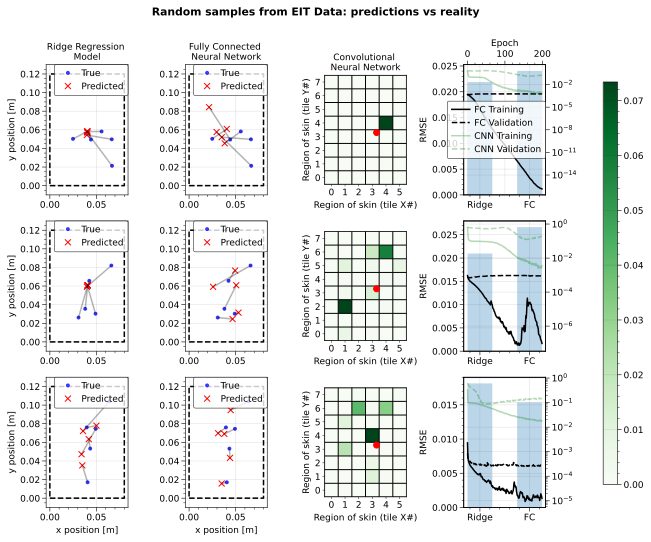

In [49]:
# make 3x3 subplots
fig, axs = plt.subplots(3, 4, figsize=(10, 8))

ax_ridge_nd, ax_fc_nd, ax_cnn_nd, ax_scores_nd = axs[0]
ax_ridge_sd, ax_fc_sd, ax_cnn_sd, ax_scores_sd = axs[1]
ax_ridge_sn, ax_fc_sn, ax_cnn_sn, ax_scores_sn = axs[2]

# draw 5 random samples from the test set: X_nd_test, y_nd_test
sample_indices = np.random.randint(0, len(X_nd_test), size=5)
X_nd_sample = X_nd_test[sample_indices]
y_nd_sample = y_nd_test[sample_indices]
y_nd_ridge_sample_pred = ridge_nd_model.predict(X_nd_sample)
y_nd_fc_sample_pred = fc_nd_model.predict(X_nd_sample)
y_nd_cnn_sample_pred = cnn_nd_model.predict(X_nd_sample)

X_sd_sample = X_sd_test[sample_indices]
y_sd_sample = y_sd_test[sample_indices]
y_sd_ridge_sample_pred = ridge_sd_model.predict(X_sd_sample)
y_sd_fc_sample_pred = fc_sd_model.predict(X_sd_sample)
y_sd_cnn_sample_pred = cnn_sd_model.predict(X_sd_sample)

X_sn_sample = X_sn_test[sample_indices]
y_sn_sample = y_sn_test[sample_indices]
y_sn_ridge_sample_pred = ridge_sn_model.predict(X_sn_sample)
y_sn_fc_sample_pred = fc_sn_model.predict(X_sn_sample)
y_sn_cnn_sample_pred = cnn_sn_model.predict(X_sn_sample)

xy_to_tile = lambda x, y: [x / FRAME_X * GRID_DIV_X, y / FRAME_Y * GRID_DIV_Y]
y_nd_sample_tile = np.array(xy_to_tile(*y_nd_sample.T)).T
y_sd_sample_tile = np.array(xy_to_tile(*y_sd_sample.T)).T
y_sn_sample_tile = np.array(xy_to_tile(*y_sn_sample.T)).T

# title and labels
fig.suptitle('Random samples from EIT Data: predictions vs reality')
ax_ridge_nd.set_title('Ridge Regression \nModel')
ax_fc_nd.set_title('Fully Connected \nNeural Network')
ax_cnn_nd.set_title('Convolutional \nNeural Network')
for ax in (ax_ridge_sn, ax_fc_sn):
    ax.set_xlabel('x position [m]')
for ax in (ax_ridge_nd, ax_ridge_sd, ax_ridge_sn):
    ax.set_ylabel('y position [m]')
for ax in (ax_cnn_nd, ax_cnn_sd, ax_cnn_sn):
    ax.set_xlabel('Region of skin (tile X#)')
    ax.set_ylabel('Region of skin (tile Y#)')
    
for ax in axs[:, :3].flatten():
    ax.set_xlim([0, FRAME_X])
    ax.set_ylim([0, FRAME_Y])

# plot the ridge results
ax_ridge_nd.plot(y_nd_sample[:, 0], y_nd_sample[:, 1], 'b.', label=f'True', alpha=0.7)
ax_ridge_nd.plot(y_nd_ridge_sample_pred[:, 0], y_nd_ridge_sample_pred[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_nd_sample)):
    ax_ridge_nd.plot([y_nd_sample[i, 0], y_nd_ridge_sample_pred[i, 0]], [y_nd_sample[i, 1], y_nd_ridge_sample_pred[i, 1]],
        'k-', alpha=0.3)
ax_ridge_nd.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_ridge_nd.axis('equal')
ax_ridge_nd.legend(loc='upper right')

ax_ridge_sd.plot(y_sd_sample[:, 0], y_sd_sample[:, 1], 'b.', label=f'True', alpha=0.7)
ax_ridge_sd.plot(y_sd_ridge_sample_pred[:, 0], y_sd_ridge_sample_pred[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sd_sample)):
    ax_ridge_sd.plot([y_sd_sample[i, 0], y_sd_ridge_sample_pred[i, 0]], [y_sd_sample[i, 1], y_sd_ridge_sample_pred[i, 1]],
        'k-', alpha=0.3)
ax_ridge_sd.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_ridge_sd.axis('equal')
ax_ridge_sd.legend(loc='upper right')

ax_ridge_sn.plot(y_sn_sample[:, 0], y_sn_sample[:, 1], 'b.', label=f'True', alpha=0.7)
ax_ridge_sn.plot(y_sn_ridge_sample_pred[:, 0], y_sn_ridge_sample_pred[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sn_sample)):
    ax_ridge_sn.plot([y_sn_sample[i, 0], y_sn_ridge_sample_pred[i, 0]], [y_sn_sample[i, 1], y_sn_ridge_sample_pred[i, 1]],
        'k-', alpha=0.3)
ax_ridge_sn.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_ridge_sn.axis('equal')
ax_ridge_sn.legend(loc='upper right')

# plot the fully connected neural net results
ax_fc_nd.plot(y_nd_sample[:, 0], y_nd_sample[:, 1], 'b.', label=f'True', alpha=0.7)
ax_fc_nd.plot(y_nd_fc_sample_pred[:, 0], y_nd_fc_sample_pred[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_nd_sample)):
    ax_fc_nd.plot([y_nd_sample[i, 0], y_nd_fc_sample_pred[i, 0]], [y_nd_sample[i, 1], y_nd_fc_sample_pred[i, 1]],
        'k-', alpha=0.3)
ax_fc_nd.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_fc_nd.axis('equal')
ax_fc_nd.legend(loc='upper right')

ax_fc_sd.plot(y_sd_sample[:, 0], y_sd_sample[:, 1], 'b.', label=f'True', alpha=0.7)
ax_fc_sd.plot(y_sd_fc_sample_pred[:, 0], y_sd_fc_sample_pred[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sd_sample)):
    ax_fc_sd.plot([y_sd_sample[i, 0], y_sd_fc_sample_pred[i, 0]], [y_sd_sample[i, 1], y_sd_fc_sample_pred[i, 1]],
        'k-', alpha=0.3)
ax_fc_sd.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_fc_sd.axis('equal')
ax_fc_sd.legend(loc='upper right')

ax_fc_sn.plot(y_sn_sample[:, 0], y_sn_sample[:, 1], 'b.', label=f'True', alpha=0.7)
ax_fc_sn.plot(y_sn_fc_sample_pred[:, 0], y_sn_fc_sample_pred[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sn_sample)):
    ax_fc_sn.plot([y_sn_sample[i, 0], y_sn_fc_sample_pred[i, 0]], [y_sn_sample[i, 1], y_sn_fc_sample_pred[i, 1]],
        'k-', alpha=0.3)
ax_fc_sn.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_fc_sn.axis('equal')
ax_fc_sn.legend(loc='upper right')

# plot the convolutional neural network results
for ax in (ax_cnn_nd, ax_cnn_sn, ax_cnn_sd):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(which='major', size=0, labelsize=0)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter('{x:.0f}')
    ax.yaxis.set_minor_formatter('{x:.0f}')
    ax.set_xticks(np.arange(-0.5, GRID_DIV_X + 0.5, 1))
    ax.set_yticks(np.arange(-0.5, GRID_DIV_Y + 0.5, 1))
    ax.grid(linewidth=1, visible=True, which='major', alpha=1.0)
    ax.grid(which='minor', alpha=0.0)

ax_cnn_nd.imshow(y_nd_cnn_sample_pred[0].T, cmap='Greens', vmin=0, vmax=min(1, 1 * np.max(y_nd_cnn_sample_pred[0])))
ax_cnn_nd.plot([y_nd_sample_tile[0][0]], [y_nd_sample_tile[0][1]], 'ro')
ax_cnn_sd.imshow(y_sd_cnn_sample_pred[0].T, cmap='Greens', vmin=0, vmax=min(1, 1 * np.max(y_sd_cnn_sample_pred[0])))
ax_cnn_sd.plot([y_nd_sample_tile[0][0]], [y_nd_sample_tile[0][1]], 'ro')
im = ax_cnn_sn.imshow(y_sn_cnn_sample_pred[0].T, cmap='Greens', vmin=0, vmax=min(1, 1 * np.max(y_sn_cnn_sample_pred[0])))
ax_cnn_sn.plot([y_nd_sample_tile[0][0]], [y_nd_sample_tile[0][1]], 'ro')

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

# plot the scores

ax_scores_nd.bar(['Ridge', 'FC'], [ridge_nd_rmse, fc_nd_rmse], label='RMSE', width=0.5, alpha=0.3)
ax_scores_sd.bar(['Ridge', 'FC'], [ridge_sd_rmse, fc_sd_rmse], label='RMSE', width=0.5, alpha=0.3)
ax_scores_sn.bar(['Ridge', 'FC'], [ridge_sn_rmse, fc_sn_rmse], label='RMSE', width=0.5, alpha=0.3)

ax_scores_nd_2 = ax_scores_nd.twinx().twiny()
ax_scores_sd_2 = ax_scores_sd.twinx().twiny()
ax_scores_sn_2 = ax_scores_sn.twinx().twiny()

ax_scores_nd_2.plot(fc_nd_history.history['loss'], 'k-', label='FC Training')
ax_scores_nd_2.plot(fc_nd_history.history['val_loss'], 'k--', label='FC Validation')
ax_scores_sd_2.plot(fc_sd_history.history['loss'], 'k-', label='FC Training')
ax_scores_sd_2.plot(fc_sd_history.history['val_loss'], 'k--', label='FC Validation')
ax_scores_sn_2.plot(fc_sn_history.history['loss'], 'k-', label='FC Training')
ax_scores_sn_2.plot(fc_sn_history.history['val_loss'], 'k--', label='FC Validation')

ax_scores_nd_2.plot(cnn_nd_history.history['loss'], 'g-', label='CNN Training', alpha=0.3)
ax_scores_nd_2.plot(cnn_nd_history.history['val_loss'], 'g--', label='CNN Validation', alpha=0.3)
ax_scores_sd_2.plot(cnn_sd_history.history['loss'], 'g-', label='CNN Training', alpha=0.3)
ax_scores_sd_2.plot(cnn_sd_history.history['val_loss'], 'g--', label='CNN Validation', alpha=0.3)
ax_scores_sn_2.plot(cnn_sn_history.history['loss'], 'g-', label='CNN Training', alpha=0.3)
ax_scores_sn_2.plot(cnn_sn_history.history['val_loss'], 'g--', label='CNN Validation', alpha=0.3)

for i, ax in enumerate((ax_scores_nd, ax_scores_sd, ax_scores_sn)):
    ax.set_ylabel('RMSE')
for i, ax2 in enumerate((ax_scores_nd_2, ax_scores_sd_2, ax_scores_sn_2)):
    ax2.set_ylabel('Loss')
    ax2.set_yscale('log')
    ax2.set_ylabel('Loss')
    if i == 0:
        ax2.set_xlabel('Epoch')
        ax2.legend()
    else:
        ax2.set_xticks(ticks=[], labels=[])

plt.subplots_adjust(wspace=0.7)

fig.savefig('/kaggle/working/Figure_3.pdf')
fig.savefig('/kaggle/working/Figure_3.svg')

plt.show()